# Is the network right?

We inspect trained models to understand if:
- the model is able to extract visual features

In [10]:
import torch, gym, sneks, sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('..')
from dqn.qnetwork import QNetwork
from common.atari_wrappers import ScaledFloatFrame
from common.pytorch_utils import ImageToPyTorch, NHWC_from_NCHW

## Creating the testing environment

In [6]:
def make_env(env_name, rnd_seed):
    env = gym.make(env_name)
    env = ScaledFloatFrame(env)
    env = ImageToPyTorch(env)
    env.seed(rnd_seed)
    return env

env = make_env('snek-rgb-16-v1', 42)

In [7]:
obs = env.reset()

/home/tesla/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'common.atari_wrappers.ScaledFloatFrame'> doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


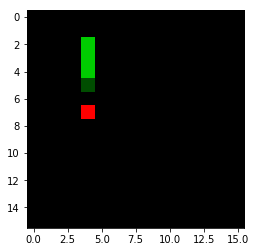

In [12]:
plt.imshow(NHWC_from_NCHW(obs))
plt.show();

ACTIONS:
  - 0: UP
  - 1: RIGHT
  - 2: DOWN
  - 3: LEFT

## Loading the trained network

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = torch.load('../qnetwork.pth', map_location="cuda" if torch.cuda.is_available() else "cpu")
print("ARCH:", state['arch'])
net = QNetwork(env.observation_space, env.action_space, arch=state['arch']).to(device)
net.load_state_dict(state['state_dict'])

ARCH: smally


In [20]:
net

QNetwork(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
      (1): ReLU()
    )
  )
  (head): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10816, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [19]:
net(torch.from_numpy(np.expand_dims(obs, 0)).to(device))

tensor([[3.9578, 4.3319, 4.1888, 4.2533]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [33]:
layer1 = net.conv_layers[0](torch.from_numpy(np.expand_dims(obs, 0)).to(device))
layer1 = NHWC_from_NCHW(layer1.cpu().detach().numpy())[0]
print(layer1.shape)

(13, 13, 64)


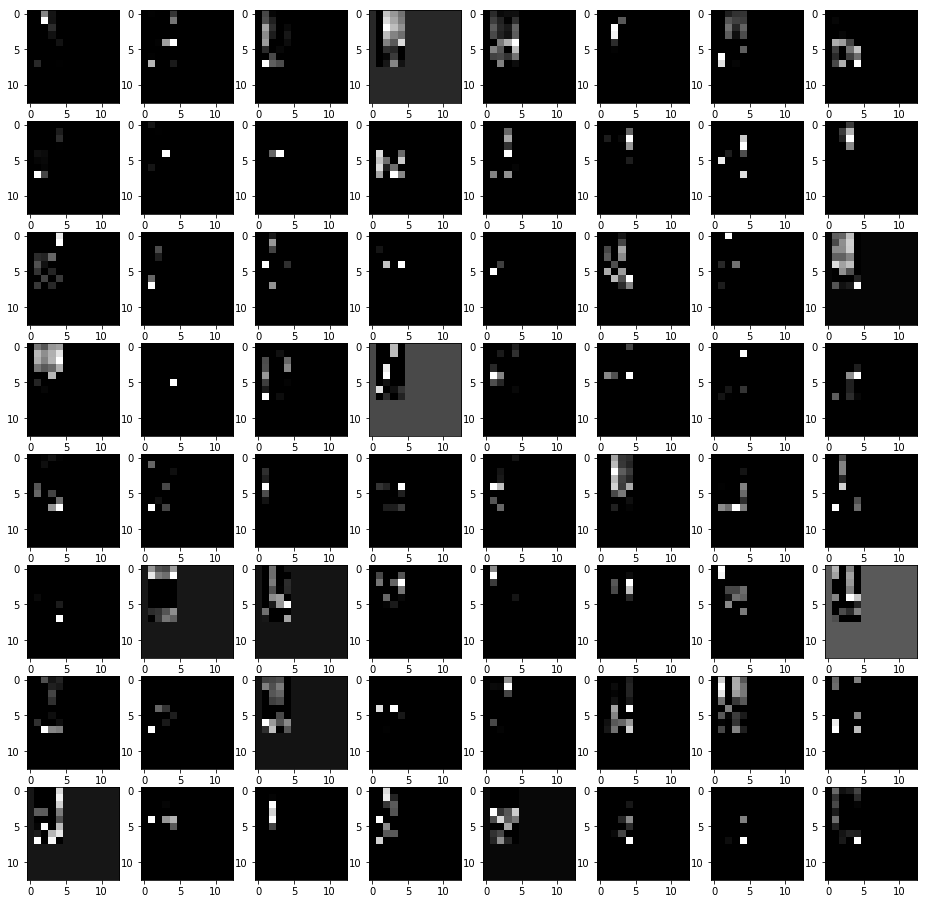

In [36]:
fig, ax = plt.subplots(8, 8, figsize=(16, 16))
for i in range(64):
    ax[i//8, i%8].imshow(layer1[:,:,i], cmap='gray')
plt.show();